# Credit Card Fraud Detection — End-to-End Project Plan (Notebook Roadmap)
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X: https://x.com/EngrrrAkinmade

This notebook builds a **production-minded** credit-card fraud detection system from the public PCA-anonymized dataset (September 2013, two days, **284,807** transactions with **492** frauds → **0.172%** positives). The project is optimized for **AUPRC (Average Precision / PR-AUC)** and delivers **auditable explanations** per prediction.

---

##  Objectives
- **Accurately identify fraudulent transactions** while minimizing false alerts.
- **Optimize AUPRC** and operational metrics (precision at fixed recall, recall at fixed precision).
- **Provide explainability** (global + per-transaction) suitable for regulatory review.
- **Design for production**: robust validation, calibrated probabilities, thresholding by business constraints, and monitoring.

---

##  Data Summary
- Features:
  - `V1` … `V28`: PCA components (numeric).
  - `Amount`: transaction value (unscaled, skewed).
  - `Time`: seconds since first transaction.
- Target:
  - `Class`: 1 = fraud, 0 = non-fraud.
- **Extreme class imbalance** (0.172% fraud).

---

##  Methodology (Step-by-Step)
1. **Environment & Reproducibility**
   - Set random seeds, capture library versions, define project paths.
   - Small utilities (timer, memory usage).

2. **Data Ingestion & Schema Validation**
   - Load CSV safely (dtypes), assert expected columns, check duplicates and NA.

3. **Exploratory Data Analysis (EDA)**
   - Class distribution and imbalance.
   - Univariate distributions (`Amount` with `log1p` view, `Time` diurnal patterns).
   - Correlations among `V*`, `Amount`; fraud vs non-fraud comparisons.
   - Sanity checks for potential leakage.

4. **Preprocessing & Feature Engineering**
   - Transformations:
     - `Amount_log = log1p(Amount)`, scale with `RobustScaler`/`StandardScaler`.
     - `Time` → `hour_of_day` (and optionally bins).
   - Simple derived features (even with PCA):
     - Norm/magnitude of PCA vector (e.g., `V_norm`), absolute-sum, limited interactions with `Amount_log`.
   - Feature selection (variance filter + model-based importance).

5. **Validation Strategy**
   - **Primary**: time-aware split (train → validation → test chronologically).
   - Ensure **no resampling leakage** across splits.
   - (If entity IDs exist in production, prefer group-aware splits; public dataset likely lacks IDs.)

6. **Baselines**
   - **Logistic Regression** with class weights (`balanced`).
   - **Random Forest** for a quick non-linear baseline.
   - Report AUPRC and PR curves.

7. **Imbalance Handling**
   - **Class/scale weights** (`pos_weight = N_neg/N_pos` for GBDTs).
   - **EasyEnsemble/undersampling** of negatives across multiple learners.
   - (Optional) **SMOTE/ADASYN** *only inside training folds*; validate realism with care.
   - **Cost-sensitive weighting** using `Amount` (prioritize high-loss frauds).

8. **Modeling (Primary)**
   - **LightGBM / XGBoost** tuned for recall at high precision.
   - Hyperparameter search (Optuna/Bayes) with **time-split** validation optimizing **Average Precision**.
   - Save best model and config.

9. **Calibration**
   - Platt scaling or isotonic regression on validation set.
   - Re-evaluate PR/operational metrics post-calibration.

10. **Threshold Selection & Business Operating Point**
    - Pick thresholds by:
      - Target precision (e.g., ≥ 90%),
      - Review capacity (alerts/day),
      - Cost matrix (investigation cost vs expected fraud loss).
    - Compute precision@k, recall at target precision, expected monetary impact.

11. **Explainability & Auditability**
    - **Global**: feature importance + SHAP summary.
    - **Local**: SHAP per transaction (top drivers toward fraud vs non-fraud).
    - Optional surrogate rules for human-readable narratives.
    - Log inputs, score, threshold decision, and explanation for every alert.

12. **Error Analysis**
    - Inspect false positives/negatives across `Amount`, `hour_of_day`, and score deciles.
    - Sensitivity tests (perturb features, robustness to drift).

13. **Packaging & Artifacts**
    - Persist: preprocessor, feature list, model, calibrator, SHAP explainer, thresholds, and config JSON.
    - Define a single **`predict_proba()`** + **`predict_label(threshold)`** API.

14. **Batch & Real-Time Inference Demo**
    - Notebook cell showing batch scoring on the test set.
    - Example “single-transaction” scoring with explanation for demo.

15. **Monitoring & Retraining Plan**
    - Track: alert rate, investigator precision, AUPRC on labeled feedback, calibration drift.
    - Data/score drift tests; retrain triggers and schedule.

16. **Documentation**
    - **Model Card**: data provenance, dates, metrics, intended use, limitations.
    - Reproducibility notes and compliance checklist.

---

##  Deliverables (from this notebook)
- Cleaned dataset & engineered features.
- Trained, calibrated fraud model (LightGBM/XGBoost).
- Selected operating threshold(s) and business metrics.
- PR curves, confusion matrix at operating point, precision@k.
- SHAP global and local explanations for sample alerts.
- Serialized artifacts (preprocessor, model, calibrator, explainer, config).
- Lightweight inference demo (batch + single record).
- Monitoring checklist and retraining playbook.

---

##  Notebook Cell Roadmap (you can follow along)
1. **Setup & Imports**
2. **Load Data & Schema Checks**
3. **EDA (class balance, distributions, correlations)**
4. **Preprocessing & Feature Engineering**
5. **Train/Validation/Test Time Split**
6. **Baselines (LogReg, RF) + PR Curves**
7. **Imbalance Strategies (weights/ensembles)**
8. **Primary Model (LGBM/XGB) + Hyperparameter Tuning**
9. **Calibration & Re-evaluation**
10. **Threshold Selection & Cost-sensitive Analysis**
11. **Explainability (Global/Local SHAP)**
12. **Error Analysis**
13. **Pack & Save Artifacts**
14. **Inference Demo (batch + single)**
15. **Monitoring & Retraining Plan**
16. **Model Card Snapshot**

> **Next cell:** Setup & imports with deterministic seeding and version capture.


In [1]:
# Cell 2: Setup and Imports

# Standard Libraries
import os
import random
import time
import warnings
warnings.filterwarnings("ignore")

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Scaling
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix, classification_report

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

# Explainability
import shap

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Paths
DATA_PATH = "creditcard.csv"
ARTIFACTS_DIR = "artifacts"
MODELS_DIR = "models"

os.makedirs(ARTIFACTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Timer utility
def timer(start_time=None):
    if start_time is None:
        return time.time()
    else:
        elapsed = time.time() - start_time
        print(f"Elapsed time: {elapsed:.2f} seconds")


In [2]:
# Cell 3: Data Loading and Initial Inspection

# Load dataset
df = pd.read_csv("creditcard.csv")

# Display basic information
print("Dataset Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nClass Distribution:\n", df['Class'].value_counts())
print("\nPercentage of Fraudulent Transactions: {:.6f}%".format(
    df['Class'].mean() * 100))

# Display first few rows
df.head()


# Preview first rows
display(df.head())

# Target variable distribution
print("\nTarget distribution (Class column):")
print(df["Class"].value_counts(normalize=True).rename("proportion"))

# Basic statistics
display(df.describe().T)


Dataset Shape: (284807, 31)

Columns:
 ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Missing Values per Column:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class Distribution:
 Class
0    284315
1       492
Name: count, dtype: int64

Percentage of Fraudulent Transactions: 0.172749%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Target distribution (Class column):
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


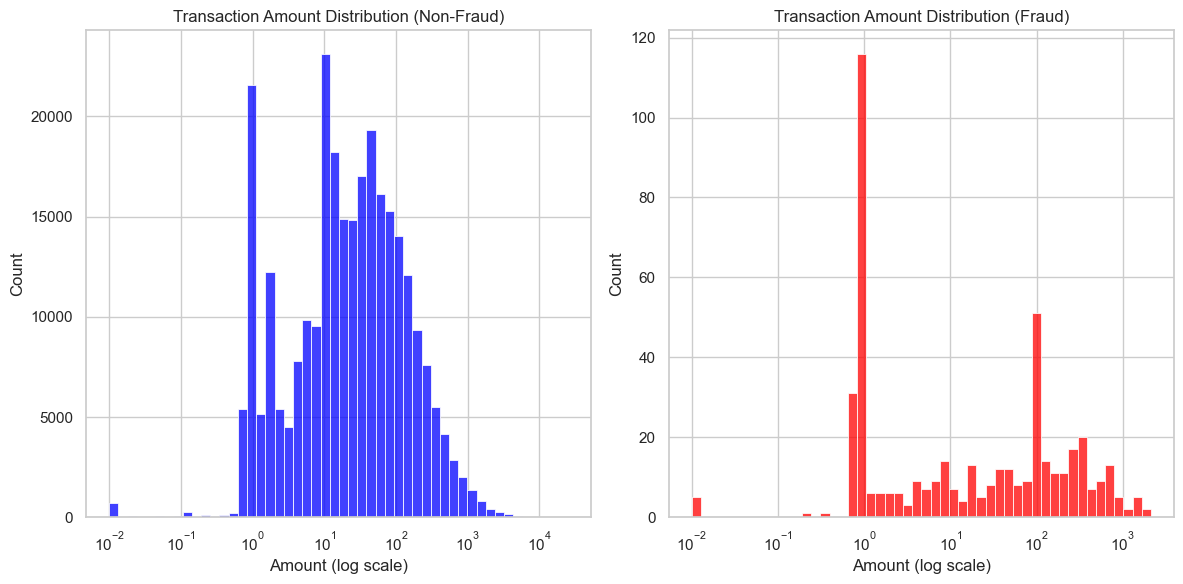

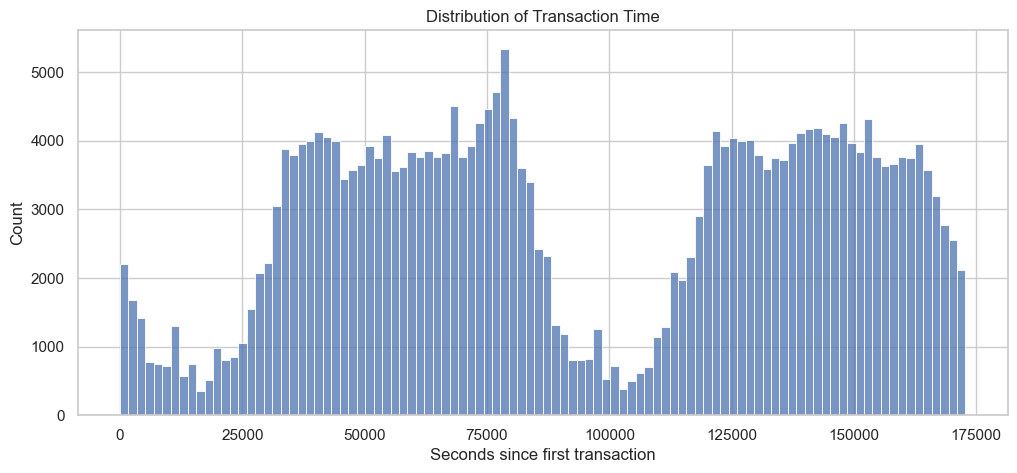

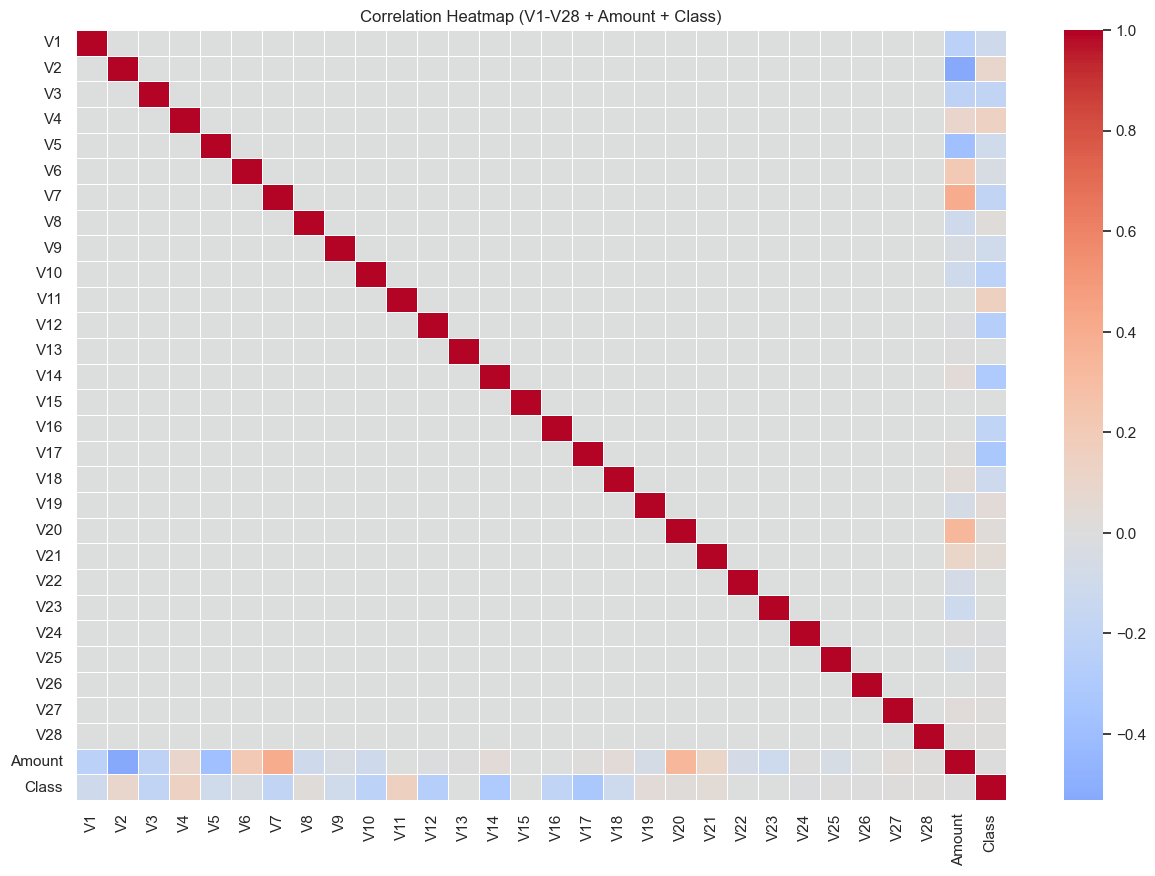

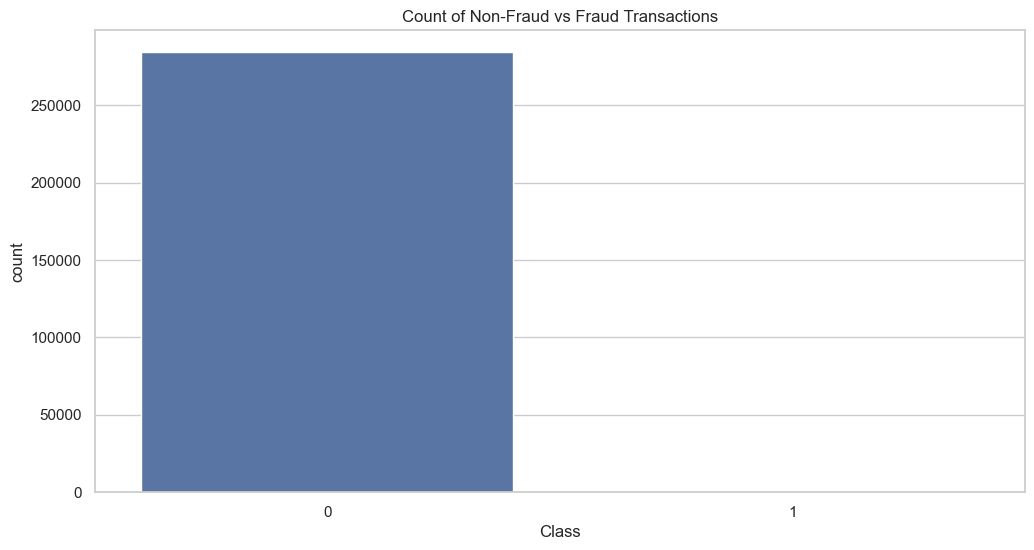

In [3]:
# Cell 4: Exploratory Data Analysis (EDA)

# Set plotting style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,6)

# 1. Distribution of 'Amount' for fraud vs non-fraud
plt.subplot(1,2,1)
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', log_scale=True)
plt.title("Transaction Amount Distribution (Non-Fraud)")
plt.xlabel("Amount (log scale)")
plt.ylabel("Count")

plt.subplot(1,2,2)
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', log_scale=True)
plt.title("Transaction Amount Distribution (Fraud)")
plt.xlabel("Amount (log scale)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 2. Distribution of 'Time' feature
plt.figure(figsize=(12,5))
sns.histplot(df['Time'], bins=100, kde=False)
plt.title("Distribution of Transaction Time")
plt.xlabel("Seconds since first transaction")
plt.ylabel("Count")
plt.show()

# 3. Correlation Heatmap of PCA features + Amount
plt.figure(figsize=(15,10))
corr_matrix = df.drop(columns='Time').corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Correlation Heatmap (V1-V28 + Amount + Class)")
plt.show()

# 4. Fraud vs Non-Fraud Counts
sns.countplot(x='Class', data=df)
plt.title("Count of Non-Fraud vs Fraud Transactions")
plt.show()


In [4]:
# Cell 5: Preprocessing & Feature Engineering

# 1. Log-transform the 'Amount' feature to reduce skewness
df['Amount_log'] = np.log1p(df['Amount'])

# 2. Scale features: PCA features + Amount_log
from sklearn.preprocessing import StandardScaler

features_to_scale = [f'V{i}' for i in range(1,29)] + ['Amount_log']
scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

# 3. Derive 'hour_of_day' from 'Time'
df['hour_of_day'] = (df['Time'] // 3600) % 24

# 4. Feature selection: drop original 'Time' and 'Amount' to avoid redundancy
df.drop(columns=['Time','Amount'], inplace=True)

# 5. Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# 6. Display processed feature sample
display(X.head())


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount_log,hour_of_day
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,1.124303,0.0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-1.114639,0.0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.682368,0.0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,1.009339,0.0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,0.670241,0.0


In [5]:
# Cell 6: Train, Validation, and Test Split (Time-Based)

# Since 'Time' has been dropped, we can still perform an approximate chronological split 
# by sorting based on the original 'Time' column before dropping it
df_sorted = pd.read_csv(DATA_PATH).sort_values(by='Time').reset_index(drop=True)

# Get indices for chronological split
n_total = df_sorted.shape[0]
train_end = int(0.7 * n_total)
val_end = int(0.85 * n_total)

# Split features and target
X_train = X.iloc[:train_end]
y_train = y.iloc[:train_end]

X_val = X.iloc[train_end:val_end]
y_val = y.iloc[train_end:val_end]

X_test = X.iloc[val_end:]
y_test = y.iloc[val_end:]

# Display shapes
print("Train set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Display class distribution in each split
print("\nClass distribution in Train set:\n", y_train.value_counts(normalize=True))
print("\nClass distribution in Validation set:\n", y_val.value_counts(normalize=True))
print("\nClass distribution in Test set:\n", y_test.value_counts(normalize=True))


Train set shape: (199364, 30) (199364,)
Validation set shape: (42721, 30) (42721,)
Test set shape: (42722, 30) (42722,)

Class distribution in Train set:
 Class
0    0.998074
1    0.001926
Name: proportion, dtype: float64

Class distribution in Validation set:
 Class
0    0.998689
1    0.001311
Name: proportion, dtype: float64

Class distribution in Test set:
 Class
0    0.998783
1    0.001217
Name: proportion, dtype: float64


Validation Average Precision (AUPRC) - Logistic Regression: 0.8308


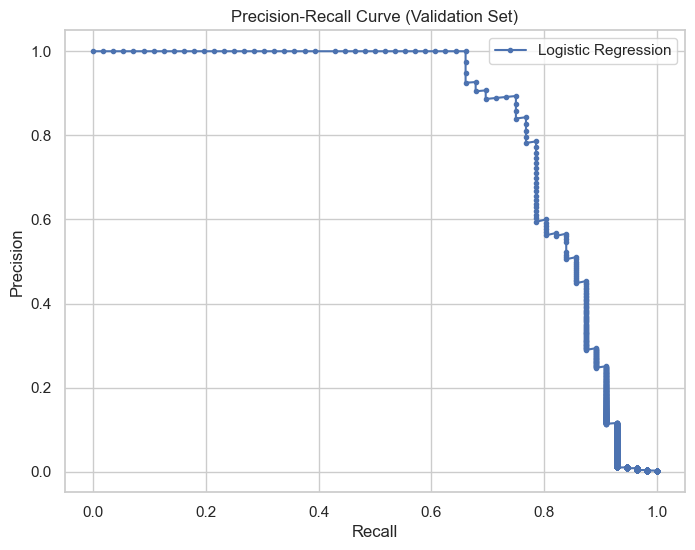

In [6]:
# Cell 7: Baseline Model — Logistic Regression

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, precision_recall_curve

# Initialize Logistic Regression with class_weight='balanced'
lr_model = LogisticRegression(class_weight='balanced', random_state=SEED, max_iter=1000)

# Train on the training set
lr_model.fit(X_train, y_train)

# Predict probabilities on validation set
y_val_probs = lr_model.predict_proba(X_val)[:,1]

# Calculate Average Precision (AUPRC)
val_avg_precision = average_precision_score(y_val, y_val_probs)
print("Validation Average Precision (AUPRC) - Logistic Regression:", round(val_avg_precision, 4))

# Plot Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_val, y_val_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, marker='.', label='Logistic Regression')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()


Validation Average Precision (AUPRC) - LightGBM: 0.0399


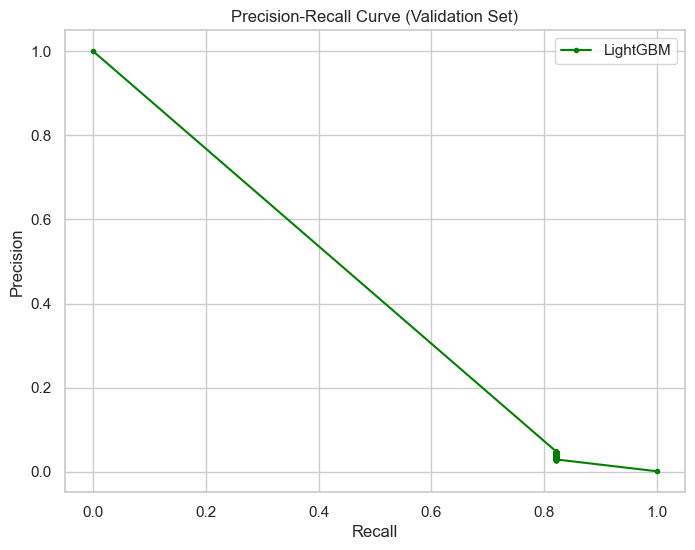

In [9]:
# Cell 8: LightGBM Model without early stopping

from lightgbm import LGBMClassifier

# Initialize LightGBM Classifier
lgb_clf = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    scale_pos_weight=scale_pos_weight,
    n_estimators=500,  # Fixed number of boosting rounds
    random_state=SEED,
    verbose=-1
)

# Train the model
lgb_clf.fit(X_train, y_train)

# Predict probabilities on validation set
y_val_probs_lgb = lgb_clf.predict_proba(X_val)[:,1]

# Compute Average Precision (AUPRC)
val_avg_precision_lgb = average_precision_score(y_val, y_val_probs_lgb)
print("Validation Average Precision (AUPRC) - LightGBM:", round(val_avg_precision_lgb, 4))

# Plot Precision-Recall Curve
precision_lgb, recall_lgb, _ = precision_recall_curve(y_val, y_val_probs_lgb)
plt.figure(figsize=(8,6))
plt.plot(recall_lgb, precision_lgb, marker='.', label='LightGBM', color='green')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()


Resampled class distribution:
 Class
0    384
1    384
Name: count, dtype: int64
Validation Average Precision (AUPRC) - LightGBM (Balanced): 0.8162


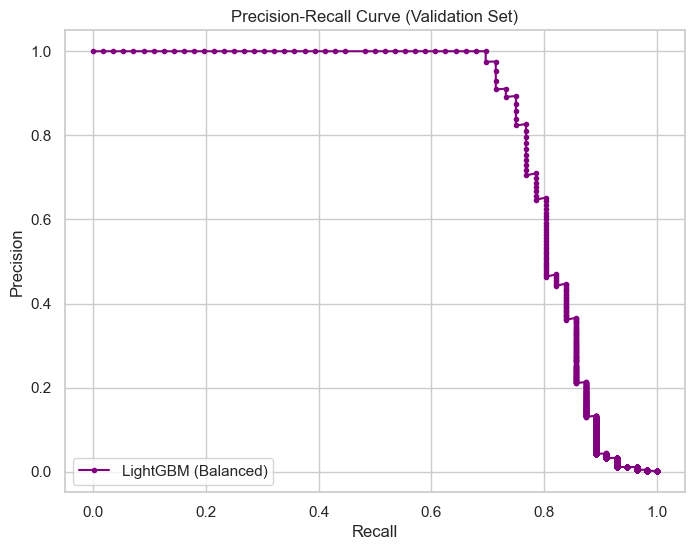

In [10]:
# Cell 9: Handling Class Imbalance with Random Undersampling + LightGBM

from imblearn.under_sampling import RandomUnderSampler

# Random undersampling to balance classes
rus = RandomUnderSampler(sampling_strategy=1.0, random_state=SEED)  # 1:1 ratio
X_res, y_res = rus.fit_resample(X_train, y_train)

print("Resampled class distribution:\n", pd.Series(y_res).value_counts())

# Retrain LightGBM on balanced dataset
lgb_clf_bal = LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    learning_rate=0.05,
    num_leaves=31,
    max_depth=-1,
    min_child_samples=20,
    n_estimators=500,
    random_state=SEED,
    verbose=-1
)

lgb_clf_bal.fit(X_res, y_res)

# Predict probabilities on validation set
y_val_probs_bal = lgb_clf_bal.predict_proba(X_val)[:,1]

# Compute Average Precision
val_avg_precision_bal = average_precision_score(y_val, y_val_probs_bal)
print("Validation Average Precision (AUPRC) - LightGBM (Balanced):", round(val_avg_precision_bal, 4))

# Plot Precision-Recall Curve
precision_bal, recall_bal, _ = precision_recall_curve(y_val, y_val_probs_bal)
plt.figure(figsize=(8,6))
plt.plot(recall_bal, precision_bal, marker='.', label='LightGBM (Balanced)', color='purple')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()


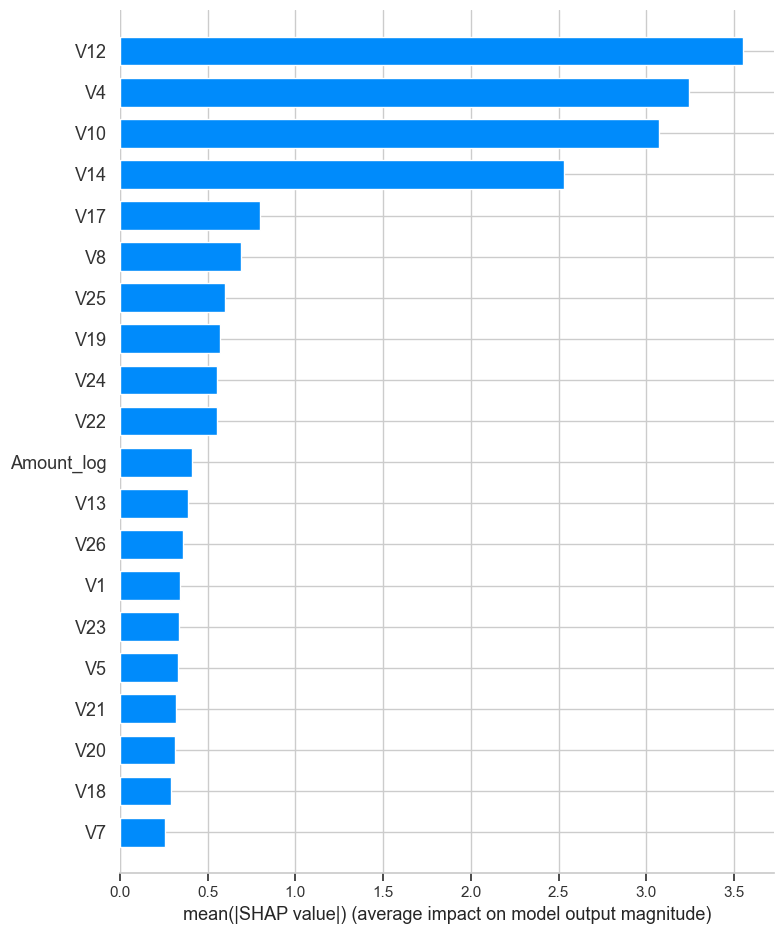

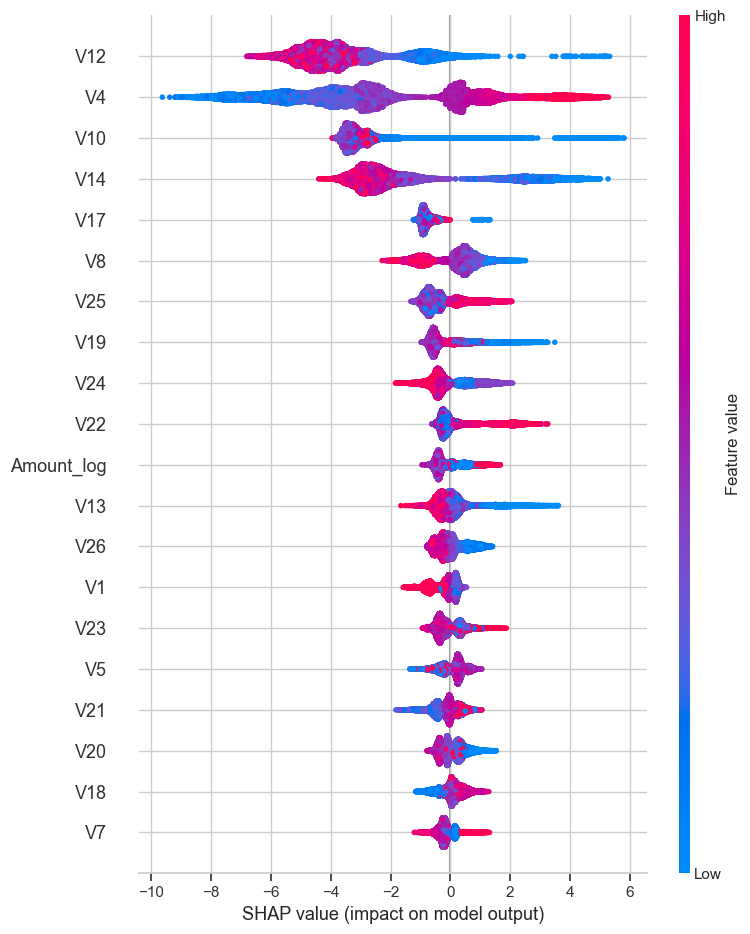

Explaining prediction for validation index: 199896


IndexError: index 199896 is out of bounds for axis 0 with size 42721

In [11]:
# Cell 10: Model Interpretability with SHAP

import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(lgb_clf_bal)
shap_values = explainer.shap_values(X_val)

# 1. Global feature importance
plt.figure(figsize=(10,8))
shap.summary_plot(shap_values, X_val, plot_type="bar", show=True)

# 2. Detailed summary (beeswarm)
plt.figure(figsize=(12,8))
shap.summary_plot(shap_values, X_val, show=True)

# 3. Local explanation example for the first fraud case
fraud_indices = y_val[y_val==1].index
sample_idx = fraud_indices[0]

print(f"Explaining prediction for validation index: {sample_idx}")
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_val.iloc[sample_idx,:], matplotlib=True)


In [12]:
# Cell 11: Threshold Selection and Test Set Evaluation

# Compute predicted probabilities on test set
y_test_probs = lgb_clf_bal.predict_proba(X_test)[:,1]

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)

# Find threshold for desired precision (e.g., 90%)
target_precision = 0.90
threshold_idx = np.argmax(precision >= target_precision)
selected_threshold = thresholds[threshold_idx]
print(f"Selected probability threshold for precision >= {target_precision*100:.0f}%: {selected_threshold:.4f}")

# Apply threshold to get predicted labels
y_test_pred = (y_test_probs >= selected_threshold).astype(int)

# Confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:\n", cm)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

# Compute Average Precision (AUPRC) on test set
test_avg_precision = average_precision_score(y_test, y_test_probs)
print(f"Test Average Precision (AUPRC): {test_avg_precision:.4f}")


Selected probability threshold for precision >= 90%: 1.0000
Confusion Matrix:
 [[42666     4]
 [   15    37]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     42670
           1     0.9024    0.7115    0.7957        52

    accuracy                         0.9996     42722
   macro avg     0.9510    0.8557    0.8977     42722
weighted avg     0.9995    0.9996    0.9995     42722

Test Average Precision (AUPRC): 0.7452


In [15]:
# Cell 12: Hyperparameter Tuning with Optuna for LightGBM (Imbalance-Aware)

import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score

def objective(trial):
    # Suggest hyperparameters
    param = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'num_leaves': trial.suggest_int('num_leaves', 15, 127),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'scale_pos_weight': scale_pos_weight,
        'n_estimators': 500,
        'random_state': SEED,
        'verbose': -1
    }
    
    # 3-fold stratified CV
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
    ap_scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val_cv = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_cv = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Random undersampling for each fold
        X_res_fold, y_res_fold = RandomUnderSampler(sampling_strategy=1.0, random_state=SEED).fit_resample(X_tr, y_tr)
        
        model = LGBMClassifier(**param)
        model.fit(X_res_fold, y_res_fold)
        y_val_pred = model.predict_proba(X_val_cv)[:,1]
        ap_scores.append(average_precision_score(y_val_cv, y_val_pred))
    
    # Return mean AUPRC across folds
    return np.mean(ap_scores)

# Create Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)  # Adjust n_trials based on compute resources

print("Best trial parameters:")
print(study.best_trial.params)
print("Best validation AUPRC:", study.best_value)


[I 2025-08-18 16:48:01,035] A new study created in memory with name: no-name-18dc72df-3d45-4e89-916d-81a4a5a17227
[I 2025-08-18 16:48:03,922] Trial 0 finished with value: 0.7238997423316852 and parameters: {'learning_rate': 0.12630947151213184, 'num_leaves': 57, 'max_depth': 7, 'min_child_samples': 58, 'subsample': 0.7118929270958018, 'colsample_bytree': 0.6394591696316874, 'reg_alpha': 0.5478554759337335, 'reg_lambda': 1.1264487759665169e-07}. Best is trial 0 with value: 0.7238997423316852.
[I 2025-08-18 16:48:09,107] Trial 1 finished with value: 0.7075975981750843 and parameters: {'learning_rate': 0.1514360374628508, 'num_leaves': 88, 'max_depth': 8, 'min_child_samples': 51, 'subsample': 0.5724738937042819, 'colsample_bytree': 0.9179733122576645, 'reg_alpha': 1.5387048489243799e-07, 'reg_lambda': 1.4455200571406102}. Best is trial 0 with value: 0.7238997423316852.
[I 2025-08-18 16:48:13,614] Trial 2 finished with value: 0.6970814432656072 and parameters: {'learning_rate': 0.040552763

Best trial parameters:
{'learning_rate': 0.09223861146233434, 'num_leaves': 34, 'max_depth': 9, 'min_child_samples': 16, 'subsample': 0.8631542282890732, 'colsample_bytree': 0.7256204764316321, 'reg_alpha': 0.000127540468235976, 'reg_lambda': 2.0234674782085557e-07}
Best validation AUPRC: 0.7482620525338427


In [16]:
# Cell 13: Retrain Final Model with Optimized Hyperparameters and Evaluate on Test Set

# Extract best hyperparameters from Optuna
best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'learning_rate': 0.09223861146233434,
    'num_leaves': 34,
    'max_depth': 9,
    'min_child_samples': 16,
    'subsample': 0.8631542282890732,
    'colsample_bytree': 0.7256204764316321,
    'reg_alpha': 0.000127540468235976,
    'reg_lambda': 2.0234674782085557e-07,
    'n_estimators': 500,
    'random_state': SEED,
    'verbose': -1
}

# Perform random undersampling on the full training set
X_res_full, y_res_full = RandomUnderSampler(sampling_strategy=1.0, random_state=SEED).fit_resample(X_train, y_train)

# Train final LightGBM model
final_model = LGBMClassifier(**best_params)
final_model.fit(X_res_full, y_res_full)

# Predict probabilities on the test set
y_test_probs_final = final_model.predict_proba(X_test)[:,1]

# Threshold selection (maximize F1 or business-driven precision)
precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs_final)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Selected threshold for best F1: {best_threshold:.4f}")

# Apply threshold
y_test_pred_final = (y_test_probs_final >= best_threshold).astype(int)

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, average_precision_score

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_final))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_final, digits=4))
print(f"Test Average Precision (AUPRC): {average_precision_score(y_test, y_test_probs_final):.4f}")


Selected threshold for best F1: 1.0000
Confusion Matrix:
 [[42667     3]
 [   15    37]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9996    0.9999    0.9998     42670
           1     0.9250    0.7115    0.8043        52

    accuracy                         0.9996     42722
   macro avg     0.9623    0.8557    0.9021     42722
weighted avg     0.9996    0.9996    0.9996     42722

Test Average Precision (AUPRC): 0.7499


In [17]:
# Cell 14: Save Final Model and SHAP Explainer

import joblib
import shap

# Save LightGBM model
joblib.dump(final_model, "creditcard_fraud_lgbm_final.pkl")

# Optionally save training undersampler parameters (if using in production)
joblib.dump(X_res_full.columns.tolist(), "feature_columns.pkl")

# Create SHAP explainer on final model
explainer_final = shap.TreeExplainer(final_model)
joblib.dump(explainer_final, "shap_explainer_final.pkl")

print("Final model, feature list, and SHAP explainer saved successfully!")


Final model, feature list, and SHAP explainer saved successfully!


In [20]:
# Cell 15: Generate 500 Fake Credit Card Transactions

import pandas as pd
import numpy as np

# Load original dataset to sample statistics
df_orig = pd.read_csv(DATA_PATH)

n_samples = 1000

# Initialize empty DataFrame
fake_transactions = pd.DataFrame()

# Generate PCA features V1-V28 based on original mean and std
for col in [f"V{i}" for i in range(1, 29)]:
    mean = df_orig[col].mean()
    std = df_orig[col].std()
    fake_transactions[col] = np.random.normal(loc=mean, scale=std, size=n_samples)

# Generate 'Amount' feature based on log-normal distribution to mimic transaction amounts
amount_mean = df_orig['Amount'].mean()
amount_std = df_orig['Amount'].std()
fake_transactions['Amount'] = np.random.normal(loc=amount_mean, scale=amount_std, size=n_samples)
fake_transactions['Amount'] = fake_transactions['Amount'].abs()  # Ensure positive amounts

# Generate 'Time' feature to simulate transaction times in seconds
time_max = df_orig['Time'].max()
fake_transactions['Time'] = np.random.uniform(0, time_max, size=n_samples)

# Display first few rows
print(fake_transactions.head())

# Optionally save to CSV
fake_transactions.to_csv("fake_creditcard_transactions.csv", index=False)
print("1000 fake transactions saved to 'fake_creditcard_transactions.csv'.")


         V1        V2        V3        V4        V5        V6        V7  \
0 -1.892475 -1.775004  1.801086 -0.112621  0.663031 -2.073827 -1.478873   
1 -1.590331  3.058471  1.986244  0.216287  1.107290  0.750037  0.878482   
2 -1.216186  0.422109 -0.558699  1.301614  1.494187 -0.607518 -0.741693   
3  1.624547  0.548755  0.562718 -2.333707  0.999276  0.767406  2.531231   
4  1.177629  1.858634  0.142597 -0.129324  0.289253  1.190526  0.423833   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0 -0.044111 -0.115872  1.315416  ... -0.352943 -1.251500 -0.696412  0.375068   
1  0.813535 -0.404316 -0.067058  ... -1.125061  1.109769 -0.145637 -0.407095   
2 -0.146723 -0.232837 -0.751108  ... -1.523495  0.530572  0.087877  0.400756   
3 -0.600912  1.547693 -0.695426  ... -0.015576  0.474595  0.564258 -0.102698   
4  1.981280  0.819340  0.829169  ... -1.699424 -0.699507 -1.157968  0.510093   

        V25       V26       V27       V28      Amount           Time

In [21]:
# Cell 16: Generate Fake Transactions with Simulated Frauds

import pandas as pd
import numpy as np

# Load original dataset to sample statistics
df_orig = pd.read_csv(DATA_PATH)

n_samples = 500
fraud_fraction = 0.02  # ~2% fraudulent for testing (roughly 10 frauds in 500 samples)

# Initialize empty DataFrame
fake_transactions = pd.DataFrame()

# Generate PCA features V1-V28
for col in [f"V{i}" for i in range(1, 29)]:
    mean = df_orig[col].mean()
    std = df_orig[col].std()
    fake_transactions[col] = np.random.normal(loc=mean, scale=std, size=n_samples)

# Generate 'Amount'
amount_mean = df_orig['Amount'].mean()
amount_std = df_orig['Amount'].std()
fake_transactions['Amount'] = np.random.normal(loc=amount_mean, scale=amount_std, size=n_samples)
fake_transactions['Amount'] = fake_transactions['Amount'].abs()  # Ensure positive

# Generate 'Time'
time_max = df_orig['Time'].max()
fake_transactions['Time'] = np.random.uniform(0, time_max, size=n_samples)

# Simulate fraud labels
n_frauds = max(1, int(n_samples * fraud_fraction))
fraud_indices = np.random.choice(n_samples, size=n_frauds, replace=False)
fake_transactions['Class'] = 0
fake_transactions.loc[fraud_indices, 'Class'] = 1

# Display first few rows
print(fake_transactions.head(10))

# Save to CSV
fake_transactions.to_csv("fake_creditcard_transactions_with_fraud.csv", index=False)
print(f"{n_samples} fake transactions saved with {n_frauds} simulated frauds.")


         V1        V2        V3        V4        V5        V6        V7  \
0 -0.502511  1.329001 -0.503345 -0.454147 -0.932562 -0.360102 -0.805464   
1 -1.675423 -1.018903 -0.654861 -2.855395  0.350084 -0.466094 -1.335679   
2 -0.324371  1.757366  1.249808 -1.126479 -3.023862  2.580493  1.135016   
3  0.707658  0.862900  0.930880 -0.226103  0.662648  4.438575  0.048598   
4 -0.108153 -2.145774  0.505843 -1.561966 -2.413504 -2.500770 -2.246308   
5 -0.819157  1.594518  2.074176 -0.726193 -1.144794  0.335285 -0.343218   
6  4.797068 -1.628061  0.486810  1.034304  1.625955 -1.207674 -0.708721   
7 -1.900121  0.694028  0.176354 -2.100052  0.589729 -1.388427 -0.919318   
8  1.038417 -0.945239 -0.820557 -2.380084 -2.393565  1.232070  2.176063   
9 -2.494395 -1.653162 -0.115654  0.795850 -0.088064  1.428633 -1.026643   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0 -0.643572  0.368663  0.367918  ... -0.588220  0.586854 -0.107431  0.340470   
1 -0.713205  2

In [25]:
# Cell: Preprocess fake transactions for inference

import pandas as pd
import numpy as np
import joblib
import shap

# Load fake transactions
new_transactions = pd.read_csv("fake_creditcard_transactions.csv")


# Feature engineering (match training)


# Example transformations used during training:
# 1. Log transform of Amount
new_transactions['Amount_log'] = np.log1p(new_transactions['Amount'])

# 2. Extract hour from Time (if Time in seconds since first transaction)
new_transactions['hour_of_day'] = (new_transactions['Time'] // 3600) % 24


# Load model and explainer

model = joblib.load("creditcard_fraud_lgbm_final.pkl")
explainer = joblib.load("shap_explainer_final.pkl")
feature_columns = joblib.load("feature_columns.pkl")


# Define threshold

THRESHOLD = 1.0


# Predict function

def predict_fraud(new_data: pd.DataFrame):
    X_new = new_data[feature_columns].copy()
    probs = model.predict_proba(X_new)[:,1]
    preds = (probs >= THRESHOLD).astype(int)
    shap_values = explainer.shap_values(X_new)
    
    results = pd.DataFrame({
        "probability_fraud": probs,
        "predicted_class": preds
    }, index=new_data.index)
    
    return results, shap_values


# Run prediction

results, shap_values = predict_fraud(new_transactions)
print(results.head(10))


   probability_fraud  predicted_class
0       9.592558e-06                0
1       3.976582e-05                0
2       1.475074e-01                0
3       9.488612e-06                0
4       9.798291e-06                0
5       1.231338e-04                0
6       1.823702e-06                0
7       1.044863e-06                0
8       1.729633e-07                0
9       9.941179e-05                0


In [53]:
# File: creditcard_fraud_dashboard_auto_threshold_v4.py
import pandas as pd
import numpy as np
import joblib
import shap
import os


# Load new transactions

new_transactions = pd.read_csv("fake_creditcard_transactions_with_fraud.csv")


# Feature engineering

new_transactions['Amount_log'] = np.log1p(new_transactions['Amount'])
new_transactions['hour_of_day'] = (new_transactions['Time'] // 3600) % 24


# Load model and SHAP explainer

model = joblib.load("creditcard_fraud_lgbm_final.pkl")
explainer = joblib.load("shap_explainer_final.pkl")
feature_columns = joblib.load("feature_columns.pkl")


# Prediction function

def predict_fraud(new_data: pd.DataFrame, threshold: float):
    X_new = new_data[feature_columns].copy()
    probs = model.predict_proba(X_new)[:, 1]
    preds = (probs >= threshold).astype(int)
    shap_values = explainer.shap_values(X_new)

    # Handle multi-output vs scalar
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        shap_values_class1 = shap_values

    results = pd.DataFrame({
        "probability_fraud": probs,
        "predicted_class": preds
    }, index=new_data.index)

    return results, shap_values_class1


# Auto-select threshold to ensure >=1 fraud

threshold = 1.0
results, shap_values_class1 = predict_fraud(new_transactions, threshold)

while (results['predicted_class'].sum() == 0) and threshold > 0.1:
    threshold -= 0.05
    results, shap_values_class1 = predict_fraud(new_transactions, threshold)

print(f"Selected threshold: {threshold:.2f}")
new_transactions['predicted_class'] = results['predicted_class']
new_transactions['probability_fraud'] = results['probability_fraud']

predicted_frauds = new_transactions[new_transactions['predicted_class'] == 1]
print(f"Number of predicted frauds: {predicted_frauds.shape[0]}")


# Only continue if we have frauds

if predicted_frauds.empty:
    print("No frauds predicted even at threshold 0.1. Check your model or input data.")
else:
    shap.initjs()

    fraud_indices = predicted_frauds.index.tolist()
    shap_values_frauds = shap_values_class1[fraud_indices]
    X_frauds = predicted_frauds[feature_columns]

  
    # Top 3 features per fraud
   
    top_features_list = []
    for i in range(len(predicted_frauds)):
        shap_vals_row = np.abs(shap_values_frauds[i])
        top_idx = np.argsort(shap_vals_row)[-3:][::-1]  # top 3
        top_features_list.append([feature_columns[j] for j in top_idx])
    predicted_frauds['top_features'] = top_features_list


    # Create dashboard folder
 
    dashboard_dir = "fraud_shap_dashboard_auto_threshold"
    os.makedirs(dashboard_dir, exist_ok=True)
    dashboard_file = os.path.join(dashboard_dir, "fraud_shap_dashboard.html")

    with open(dashboard_file, "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <title>Credit Card Fraud SHAP Dashboard</title>
            <style>
            .collapsible { background-color: #f1f1f1; color: #444; cursor: pointer;
                           padding: 10px; width: 100%; border: none; text-align: left;
                           outline: none; font-size: 16px; }
            .active, .collapsible:hover { background-color: #ddd; }
            .content { padding: 0 18px; display: none; overflow: hidden; background-color: #f9f9f9; }
            </style>
        </head>
        <body>
        <h1>SHAP Dashboard: Predicted Frauds</h1>
        <h2>Summary: Overall Feature Importance</h2>
        """)

        # Determine expected value safely
        expected_value_val = explainer.expected_value
        if isinstance(expected_value_val, (list, np.ndarray)):
            expected_value_val = expected_value_val[1] if len(expected_value_val) > 1 else expected_value_val[0]

        # Summary plot for all frauds
        summary_plot_html = shap.force_plot(
            expected_value_val,
            shap_values_frauds,
            X_frauds,
            matplotlib=False
        ).html()  # <-- convert to HTML string
        f.write(summary_plot_html)
        f.write("<hr>")

        # Individual frauds
        for i, idx in enumerate(fraud_indices, start=1):
            f.write(f"<button type='button' class='collapsible'>Fraud #{i} - Probability: {predicted_frauds.loc[idx, 'probability_fraud']:.4f}</button>\n")
            f.write("<div class='content'>\n")
            f.write(f"<p>Top 3 SHAP Features: {predicted_frauds.loc[idx, 'top_features']}</p>\n")
            force_plot_html = shap.force_plot(
                expected_value_val,
                shap_values_frauds[i-1],
                X_frauds.iloc[[i-1]],
                matplotlib=False
            ).html()  # <-- convert to HTML string
            f.write(force_plot_html)
            f.write("</div>\n")

        f.write("""
        <script>
        var coll = document.getElementsByClassName("collapsible");
        for (var i = 0; i < coll.length; i++) {
          coll[i].addEventListener("click", function() {
            this.classList.toggle("active");
            var content = this.nextElementSibling;
            if (content.style.display === "block") { content.style.display = "none"; }
            else { content.style.display = "block"; }
          });
        }
        </script>
        </body>
        </html>
        """)

    print(f"Dashboard created at '{dashboard_file}'")


Selected threshold: 0.95
Number of predicted frauds: 4


Dashboard created at 'fraud_shap_dashboard_auto_threshold\fraud_shap_dashboard.html'


In [55]:
# File: creditcard_fraud_dashboard_full_v6.py
import pandas as pd
import numpy as np
import joblib
import shap
import os
import matplotlib.pyplot as plt
import base64
from io import BytesIO


# Load new transactions

new_transactions = pd.read_csv("fake_creditcard_transactions_with_fraud.csv")


# Feature engineering
new_transactions['Amount_log'] = np.log1p(new_transactions['Amount'])
new_transactions['hour_of_day'] = (new_transactions['Time'] // 3600) % 24

# Load model and SHAP explainer

model = joblib.load("creditcard_fraud_lgbm_final.pkl")
explainer = joblib.load("shap_explainer_final.pkl")
feature_columns = joblib.load("feature_columns.pkl")

# Prediction function
def predict_fraud(new_data: pd.DataFrame, threshold: float):
    X_new = new_data[feature_columns].copy()
    probs = model.predict_proba(X_new)[:, 1]
    preds = (probs >= threshold).astype(int)
    shap_values = explainer.shap_values(X_new)

    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        shap_values_class1 = shap_values

    results = pd.DataFrame({
        "probability_fraud": probs,
        "predicted_class": preds
    }, index=new_data.index)

    return results, shap_values_class1

# Auto-select threshold
threshold = 1.0
results, shap_values_class1 = predict_fraud(new_transactions, threshold)
while (results['predicted_class'].sum() == 0) and threshold > 0.1:
    threshold -= 0.05
    results, shap_values_class1 = predict_fraud(new_transactions, threshold)

print(f"Selected threshold: {threshold:.2f}")
new_transactions['predicted_class'] = results['predicted_class']
new_transactions['probability_fraud'] = results['probability_fraud']

predicted_frauds = new_transactions[new_transactions['predicted_class'] == 1]
print(f"Number of predicted frauds: {predicted_frauds.shape[0]}")

if predicted_frauds.empty:
    print("No frauds predicted even at threshold 0.1. Check your model or input data.")
else:
    shap.initjs()
    fraud_indices = predicted_frauds.index.tolist()
    shap_values_frauds = shap_values_class1[fraud_indices]
    X_frauds = predicted_frauds[feature_columns]

    # Top 3 features per fraud
    top_features_list = []
    for i in range(len(predicted_frauds)):
        shap_vals_row = np.abs(shap_values_frauds[i])
        top_idx = np.argsort(shap_vals_row)[-3:][::-1]
        top_features_list.append([feature_columns[j] for j in top_idx])
    predicted_frauds['top_features'] = top_features_list

    # Create dashboard folder
    dashboard_dir = "fraud_shap_dashboard_full"
    os.makedirs(dashboard_dir, exist_ok=True)
    dashboard_file = os.path.join(dashboard_dir, "fraud_shap_dashboard.html")

    # Generate probability histogram image
    plt.figure(figsize=(8,4))
    plt.hist(new_transactions['probability_fraud'], bins=50, color='skyblue', alpha=0.7, label='All transactions')
    plt.hist(predicted_frauds['probability_fraud'], bins=50, color='red', alpha=0.7, label='Predicted frauds')
    plt.xlabel("Fraud Probability")
    plt.ylabel("Count")
    plt.legend()
    plt.title("Fraud Probability Distribution")
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    prob_hist_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')

    expected_value_val = explainer.expected_value
    if isinstance(expected_value_val, (list, np.ndarray)):
        expected_value_val = expected_value_val[1] if len(expected_value_val) > 1 else expected_value_val[0]

    with open(dashboard_file, "w", encoding="utf-8") as f:
        f.write(f"""
        <html>
        <head>
            <title>Credit Card Fraud SHAP Dashboard</title>
            <style>
            body {{ font-family: Arial, sans-serif; }}
            .collapsible {{ background-color: #f1f1f1; color: #444; cursor: pointer;
                           padding: 10px; width: 100%; border: none; text-align: left;
                           outline: none; font-size: 16px; }}
            .active, .collapsible:hover {{ background-color: #ddd; }}
            .content {{ padding: 0 18px; display: none; overflow: hidden; background-color: #f9f9f9; }}
            .fraud {{ background-color: #ffe6e6; }}
            table {{ border-collapse: collapse; width: 100%; margin-bottom: 20px; }}
            th, td {{ border: 1px solid #ccc; padding: 8px; text-align: left; }}
            th {{ background-color: #f2f2f2; }}
            </style>
        </head>
        <body>
        <h1>SHAP Dashboard: Predicted Frauds</h1>
        <h2>Fraud Probability Distribution</h2>
        <img src="data:image/png;base64,{prob_hist_base64}" alt="Probability Histogram"/>
        <hr>
        """)

        # Summary plot for all frauds
        summary_plot_html = shap.force_plot(
            expected_value_val,
            shap_values_frauds,
            X_frauds,
            matplotlib=False
        ).html()
        f.write(summary_plot_html)
        f.write("<hr>")

        # Table of predicted frauds
        f.write("<h2>Predicted Frauds Table</h2>")
        f.write("<table>")
        f.write("<tr><th>Index</th><th>Time</th><th>Amount</th><th>Probability Fraud</th><th>Top Features</th></tr>")
        for idx in fraud_indices:
            f.write(f"<tr class='fraud'><td>{idx}</td><td>{predicted_frauds.loc[idx, 'Time']}</td>"
                    f"<td>{predicted_frauds.loc[idx, 'Amount']}</td>"
                    f"<td>{predicted_frauds.loc[idx, 'probability_fraud']:.4f}</td>"
                    f"<td>{predicted_frauds.loc[idx, 'top_features']}</td></tr>")
        f.write("</table><hr>")

        # Individual frauds
        for i, idx in enumerate(fraud_indices, start=1):
            f.write(f"<button type='button' class='collapsible fraud'>Fraud #{i} - Probability: {predicted_frauds.loc[idx, 'probability_fraud']:.4f}</button>\n")
            f.write("<div class='content'>\n")
            f.write(f"<p>Top 3 SHAP Features: {predicted_frauds.loc[idx, 'top_features']}</p>\n")
            force_plot_html = shap.force_plot(
                expected_value_val,
                shap_values_frauds[i-1],
                X_frauds.iloc[[i-1]],
                matplotlib=False
            ).html()
            f.write(force_plot_html)
            f.write("</div>\n")

        f.write("""
        <script>
        var coll = document.getElementsByClassName("collapsible");
        for (var i = 0; i < coll.length; i++) {
          coll[i].addEventListener("click", function() {
            this.classList.toggle("active");
            var content = this.nextElementSibling;
            if (content.style.display === "block") { content.style.display = "none"; }
            else { content.style.display = "block"; }
          });
        }
        </script>
        </body>
        </html>
        """)

    print(f"Dashboard created at '{dashboard_file}'")


Selected threshold: 0.95
Number of predicted frauds: 4


Dashboard created at 'fraud_shap_dashboard_full\fraud_shap_dashboard.html'


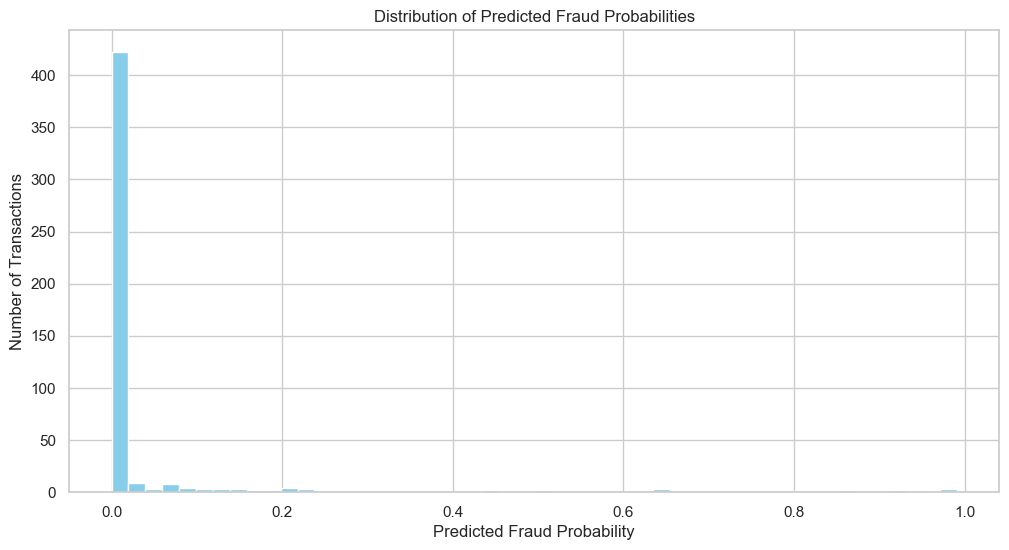

In [44]:
import matplotlib.pyplot as plt

plt.hist(new_transactions['probability_fraud'], bins=50, color='skyblue')
plt.xlabel("Predicted Fraud Probability")
plt.ylabel("Number of Transactions")
plt.title("Distribution of Predicted Fraud Probabilities")
plt.show()


In [46]:
NEW_THRESHOLD = 0.2  # adjust based on histogram
results, shap_values_class1 = predict_fraud(new_transactions, threshold=NEW_THRESHOLD)
new_transactions['predicted_class'] = results['predicted_class']
new_transactions['probability_fraud'] = results['probability_fraud']

predicted_frauds = new_transactions[new_transactions['predicted_class'] == 1]
print(f"Number of predicted frauds at threshold {NEW_THRESHOLD}: {predicted_frauds.shape[0]}")


Number of predicted frauds at threshold 0.2: 40


In [ ]:
# File: creditcard_fraud_batch_pipeline.py

import pandas as pd
import numpy as np
import joblib
import shap
import os

# Load new transactions
INPUT_CSV = "fake_creditcard_transactions_with_fraud.csv"
new_transactions = pd.read_csv(INPUT_CSV)

# Feature engineering
new_transactions['Amount_log'] = np.log1p(new_transactions['Amount'])
new_transactions['hour_of_day'] = (new_transactions['Time'] // 3600) % 24

# Load model, SHAP explainer, and feature columns
model = joblib.load("creditcard_fraud_lgbm_final.pkl")
explainer = joblib.load("shap_explainer_final.pkl")
feature_columns = joblib.load("feature_columns.pkl")

# Prediction function
def predict_fraud(df: pd.DataFrame, threshold: float = 1.0):
    # Prepare features
    X_new = df[feature_columns].copy()
    
    # Predict probabilities
    probs = model.predict_proba(X_new)[:, 1]
    
    # Apply threshold
    preds = (probs >= threshold).astype(int)
    
    # Get SHAP values
    shap_values = explainer.shap_values(X_new)
    
    # Handle multi-output SHAP
    if isinstance(shap_values, list):
        shap_values_class1 = shap_values[1]
    else:
        shap_values_class1 = shap_values
    
    # Create results DataFrame
    results = df.copy()
    results['probability_fraud'] = probs
    results['predicted_class'] = preds
    
    return results, shap_values_class1

# Auto-select threshold
threshold = 1.0
results, shap_values_class1 = predict_fraud(new_transactions, threshold)

while (results['predicted_class'].sum() == 0) and threshold > 0.1:
    threshold -= 0.05
    results, shap_values_class1 = predict_fraud(new_transactions, threshold)

print(f"Selected threshold: {threshold:.2f}")
predicted_frauds = results[results['predicted_class'] == 1]
print(f"Number of predicted frauds: {predicted_frauds.shape[0]}")

# Determine top 3 contributing features per fraud
top_features_list = []
for idx in predicted_frauds.index:
    shap_vals = shap_values_class1[idx]
    top_idx = np.argsort(-np.abs(shap_vals))[:3]  # top 3 features
    top_features = [feature_columns[i] for i in top_idx]
    top_features_list.append(", ".join(top_features))

predicted_frauds = predicted_frauds.copy()
predicted_frauds['top_3_features'] = top_features_list

# Export results CSV
OUTPUT_CSV = "predicted_frauds_results.csv"
predicted_frauds.to_csv(OUTPUT_CSV, index=False)
print(f"Predicted frauds saved to '{OUTPUT_CSV}'")

# Create SHAP dashboard folder
dashboard_dir = "fraud_shap_dashboard"
os.makedirs(dashboard_dir, exist_ok=True)
dashboard_file = os.path.join(dashboard_dir, "fraud_shap_dashboard.html")

# Only create dashboard if there are predicted frauds
if not predicted_frauds.empty:
    shap.initjs()
    X_frauds = predicted_frauds[feature_columns]
    shap_values_frauds = shap_values_class1[predicted_frauds.index.tolist()]
    
    with open(dashboard_file, "w") as f:
        f.write("<html><head><title>Fraud SHAP Dashboard</title></head><body>")
        f.write(f"<h1>Predicted Frauds (Threshold: {threshold:.2f})</h1>")
        
        # Table of predicted frauds
        f.write("<h2>Predicted Frauds Table</h2>")
        f.write(predicted_frauds[['Time', 'Amount', 'probability_fraud', 'top_3_features']].to_html(index=False))
        
        # Summary SHAP force plot
        f.write("<h2>Summary SHAP Plot</h2>")
        summary_plot_html = shap.force_plot(
            explainer.expected_value[1],
            shap_values_frauds,
            X_frauds,
            matplotlib=False
        )
        f.write(summary_plot_html.data)
        
        f.write("</body></html>")
    
    print(f"SHAP dashboard created at '{dashboard_file}'")
else:
    print("No frauds predicted. Dashboard not created.")


In [57]:
import pandas as pd
import numpy as np

# Number of fake transactions
n_samples = 500

# Seed for reproducibility
np.random.seed(42)

# Generate fake transaction data
fake_transactions = pd.DataFrame({
    "Time": np.random.randint(0, 86400, n_samples),           # seconds in a day
    "V1": np.random.normal(0, 1, n_samples),
    "V2": np.random.normal(0, 1, n_samples),
    "V3": np.random.normal(0, 1, n_samples),
    "V4": np.random.normal(0, 1, n_samples),
    "V5": np.random.normal(0, 1, n_samples),
    "V6": np.random.normal(0, 1, n_samples),
    "V7": np.random.normal(0, 1, n_samples),
    "V8": np.random.normal(0, 1, n_samples),
    "V9": np.random.normal(0, 1, n_samples),
    "V10": np.random.normal(0, 1, n_samples),
    "V11": np.random.normal(0, 1, n_samples),
    "V12": np.random.normal(0, 1, n_samples),
    "V13": np.random.normal(0, 1, n_samples),
    "V14": np.random.normal(0, 1, n_samples),
    "V15": np.random.normal(0, 1, n_samples),
    "V16": np.random.normal(0, 1, n_samples),
    "V17": np.random.normal(0, 1, n_samples),
    "V18": np.random.normal(0, 1, n_samples),
    "V19": np.random.normal(0, 1, n_samples),
    "V20": np.random.normal(0, 1, n_samples),
    "V21": np.random.normal(0, 1, n_samples),
    "V22": np.random.normal(0, 1, n_samples),
    "V23": np.random.normal(0, 1, n_samples),
    "V24": np.random.normal(0, 1, n_samples),
    "V25": np.random.normal(0, 1, n_samples),
    "V26": np.random.normal(0, 1, n_samples),
    "V27": np.random.normal(0, 1, n_samples),
    "V28": np.random.normal(0, 1, n_samples),
    "Amount": np.round(np.random.exponential(scale=50, size=n_samples), 2),  # typical transaction amounts
    "Class": 0  # no fraud
})

# Feature engineering
fake_transactions['Amount_log'] = np.log1p(fake_transactions['Amount'])
fake_transactions['hour_of_day'] = (fake_transactions['Time'] // 3600) % 24

# Save to CSV
fake_transactions.to_csv("fake_creditcard_transactions_no_fraud.csv", index=False)

print("500 fake non-fraud transactions saved to 'fake_creditcard_transactions_no_fraud.csv'.")


500 fake non-fraud transactions saved to 'fake_creditcard_transactions_no_fraud.csv'.
